In [1]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM
import pandas as pd
import os
import torch

In [2]:
def find_pkl_file(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.pkl'):
                return os.path.join(root, file)
    return None

In [3]:
# !pip install --upgrade git+https://github.com/huggingface/transformers.git

In [3]:
# seq_type = "AMP"
# cost = [0.5, 0.5, 50]


# # Index Kernel
# # https://wandb.ai/nikita0209/AMP-DKL/runs/tk7kmfj4/overview?workspace=user-nikita0209
# index_logdir = "/network/scratch/n/nikita.saxena/logs/activelearning/2023-05-01_23-18-47"
# index_pkl_file = find_pkl_file(index_logdir)
# index_culm_pkl = pd.read_pickle(index_pkl_file)
# index_culm_samples = index_culm_pkl['cumulative_sampled_samples']
# index_culm_fidelity = index_culm_pkl['cumulative_sampled_fidelities']

# # Linear Downsampling Kernel
# # https://wandb.ai/nikita0209/AMP-DKL/runs/ly838evp/overview?workspace=user-nikita0209
# linear_logdir = "/network/scratch/n/nikita.saxena/logs/activelearning/2023-05-06_14-31-20"
# linear_pkl_file = find_pkl_file(linear_logdir)
# linear_culm_pkl = pd.read_pickle(linear_pkl_file)
# linear_culm_samples = linear_culm_pkl['cumulative_sampled_samples']
# linear_culm_fidelity = linear_culm_pkl['cumulative_sampled_fidelities']

seq_type = "DNA"
cost = [0.2, 20]
k = 1024
oracle_maximize = False
# # Index Kernel
index_logdir ="/network/scratch/n/nikita.saxena/logs/activelearning/2023-05-05_14-26-31"
index_pkl_file = find_pkl_file(index_logdir)
index_culm_pkl = pd.read_pickle(index_pkl_file)
index_culm_samples = index_culm_pkl['cumulative_sampled_samples']   
index_culm_fidelity = index_culm_pkl['cumulative_sampled_fidelities']
index_culm_energies = index_culm_pkl['cumulative_sampled_energies']
index_idx_topk = torch.argsort(index_culm_energies, descending=oracle_maximize)[:k].tolist()
index_culm_samples_topk = [index_culm_samples[i] for i in index_idx_topk]
index_culm_fidelity_topk = [index_culm_fidelity[i] for i in index_idx_topk]
index_culm_samples = index_culm_samples_topk
index_culm_fidelity = index_culm_fidelity_topk
del index_culm_pkl

# # Linear Downsampling Kernel
linear_logdir = "/network/scratch/n/nikita.saxena/logs/activelearning/2023-05-06_04-35-33"
linear_pkl_file = find_pkl_file(linear_logdir)
linear_culm_pkl = pd.read_pickle(linear_pkl_file)
linear_culm_samples = linear_culm_pkl['cumulative_sampled_samples']
linear_culm_fidelity = linear_culm_pkl['cumulative_sampled_fidelities']
linear_culm_energies = linear_culm_pkl['cumulative_sampled_energies']
linear_idx_topk = torch.argsort(linear_culm_energies, descending=oracle_maximize)[:k].tolist()
linear_culm_samples_topk = [linear_culm_samples[i] for i in linear_idx_topk]
linear_culm_fidelity_topk = [linear_culm_fidelity[i] for i in linear_idx_topk]
linear_culm_samples = linear_culm_samples_topk
linear_culm_fidelity = linear_culm_fidelity_topk
del linear_culm_pkl

del index_culm_energies, linear_culm_energies, index_culm_fidelity_topk, index_culm_samples_topk, linear_culm_fidelity_topk, linear_culm_samples_topk


In [4]:
if seq_type == "AMP":
    model_name = "facebook/esm2_t6_8M_UR50D"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
elif seq_type == "DNA":
   tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref")
   model = AutoModel.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref")


Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-500m-human-ref were not used when initializing EsmModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing EsmModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmModel were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-500m-human-ref and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be ab

In [5]:
import torch

linear_sequence = linear_culm_samples
linear_inputs = tokenizer(linear_sequence, return_tensors="pt", padding=True, max_length=50)
linear_outputs = model(**linear_inputs)
linear_embeddings = linear_outputs.last_hidden_state
del linear_sequence, linear_inputs, linear_outputs, linear_culm_samples

index_sequence = index_culm_samples
index_inputs = tokenizer(index_sequence, return_tensors="pt", padding=True, max_length=50)
index_outputs = model(**index_inputs)
index_embeddings = index_outputs.last_hidden_state
del index_sequence, index_inputs, index_outputs, index_culm_samples

del model, tokenizer


/home/mila/n/nikita.saxena/mfenv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


: 

: 

In [ ]:
# linear_embeddings = linear_embeddings.cpu().detach().numpy()
if isinstance(linear_culm_fidelity, list):
    linear_culm_fidelity = torch.tensor(linear_culm_fidelity)
linear_fids = linear_culm_fidelity.cpu().detach().numpy()

index_embeddings = index_embeddings.cpu().detach().numpy()
if isinstance(index_culm_fidelity, list) == True:
    index_culm_fidelity = torch.tensor(index_culm_fidelity)
    
index_fids = index_culm_fidelity.cpu().detach().numpy()



In [ ]:
from sklearn.manifold import TSNE

# Assume `embeddings` is a NumPy array of shape (n, L, 8192)
# where n is the number of input sequences
linear_n, linear_L, linear_d = linear_embeddings.shape
index_n, index_L, index_d = index_embeddings.shape

# Reshape the embeddings to be 2-dimensional
linear_X = linear_embeddings.reshape(linear_n, linear_L*linear_d)
index_X = index_embeddings.reshape(index_n, index_L*index_d)
del linear_embeddings, index_embeddings

# numpy array of protein embeddings called `embeddings` with shape (num_proteins, embedding_size)
# create a t-SNE object with desired parameters
tsne = TSNE(n_components=2, perplexity=30, n_iter=250, random_state=42)

# apply t-SNE to the embeddings to get a 2D representation
index_tsne_embeddings = tsne.fit_transform(index_X)
linear_tsne_embeddings = tsne.fit_transform(linear_X)

Text(0.5, 0.98, 't-SNE visualization of DNA embeddings')

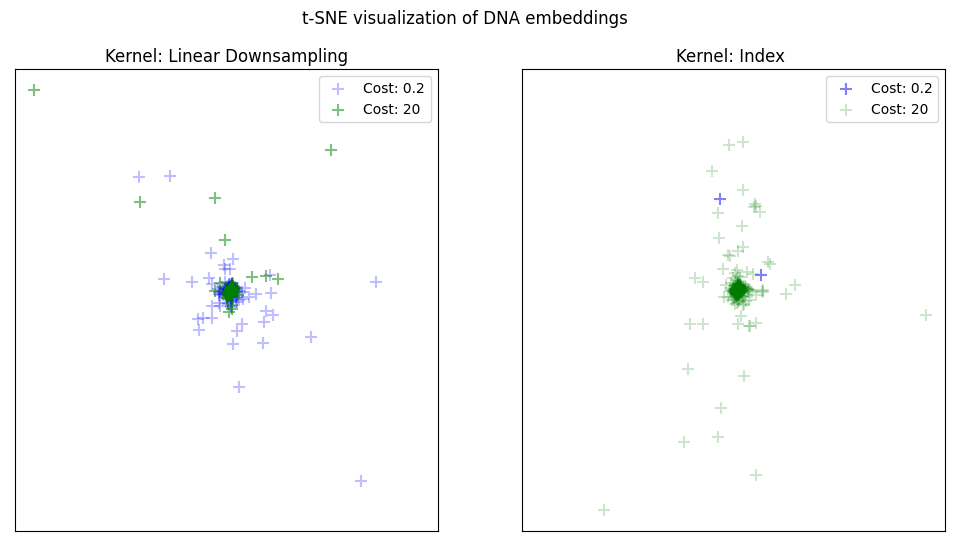

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

if seq_type == "AMP":
    fid_color = {0: 'b', 1: 'g', 2: 'r'}
    alpha_index = {0: 0.5, 1: 0.5, 2: 0.2}
    alpha_linear = {0: 0.25, 1: 0.25, 2: 0.5}
elif seq_type == "DNA":
    fid_color = {0: 'b', 1: 'g'}
    alpha_index = {0: 0.5, 1: 0.2}
    alpha_linear = {0: 0.25, 1: 0.5}

handle = []
for c in cost:
    handle.append('Cost: ' + str(c))

for fid in np.unique(linear_fids):
    # get indices of samples with this class label
    linear_idx = np.where(linear_fids == fid)[0]
    index_idx = np.where(index_fids == fid)[0]
    color = fid_color[fid]
    # print(fid)
    ax[0].scatter(linear_tsne_embeddings[linear_idx, 0], linear_tsne_embeddings[linear_idx, 1], color=color, alpha=alpha_linear[fid], marker='+', s=80, label=handle[int(fid)])
    ax[1].scatter(index_tsne_embeddings[index_idx, 0], index_tsne_embeddings[index_idx, 1], color=color, alpha=alpha_index[fid], marker='+', s=80, label=handle[int(fid)])

ax[0].set_title('Kernel: Linear Downsampling'.format(seq_type))
ax[1].set_title('Kernel: Index '.format(seq_type))

for a in ax:
    # remove x and y axis ticks
    a.set_xticks([])
    a.set_yticks([])
    a.legend()

fig.suptitle('t-SNE visualization of {} embeddings'.format(seq_type))


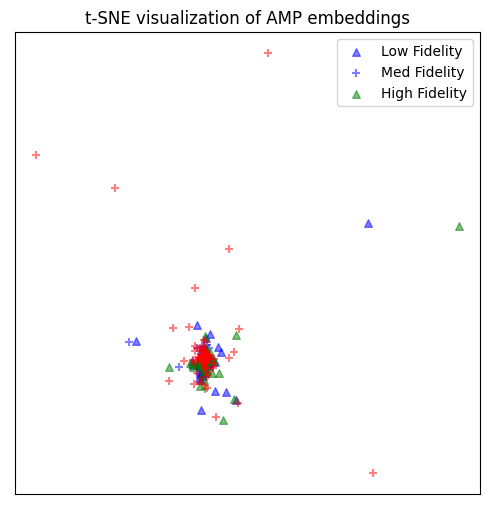

In [23]:
# # plot the t-SNE embeddings with different colors for different classes
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# # remove x and y axis ticks
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_title('t-SNE visualization of {} embeddings'.format(seq_type))

# # assume you have a numpy array of class labels called `fidelity`
# # with shape (num_proteins,)
# fid_color = {0: 'b', 1: 'g', 2: 'r'}
# alpha = {0: 0.5, 1: 0.5, 2: 0.5}


# for fid in np.unique(linear_fids):
#     # get indices of samples with this class label
#     linear_idx = np.where(linear_fids == fid)[0]
#     index_idx = np.where(index_fids == fid)[0]
#     color = fid_color[fid]
#     ax.scatter(linear_tsne_embeddings[linear_idx, 0], linear_tsne_embeddings[linear_idx, 1], color=color, alpha=alpha[fid], marker='^', s=30)
#     ax.scatter(index_tsne_embeddings[index_idx, 0], index_tsne_embeddings[index_idx, 1], color=color, alpha=alpha[fid], marker='+', s=30)

# # label='Linear DKL'
# # label='Index DKL'

# ax.legend(['Low Fidelity', 'Med Fidelity', 'High Fidelity'])

# plt.show()


Text(0.5, 0.98, 't-SNE visualization of AMP embeddings')

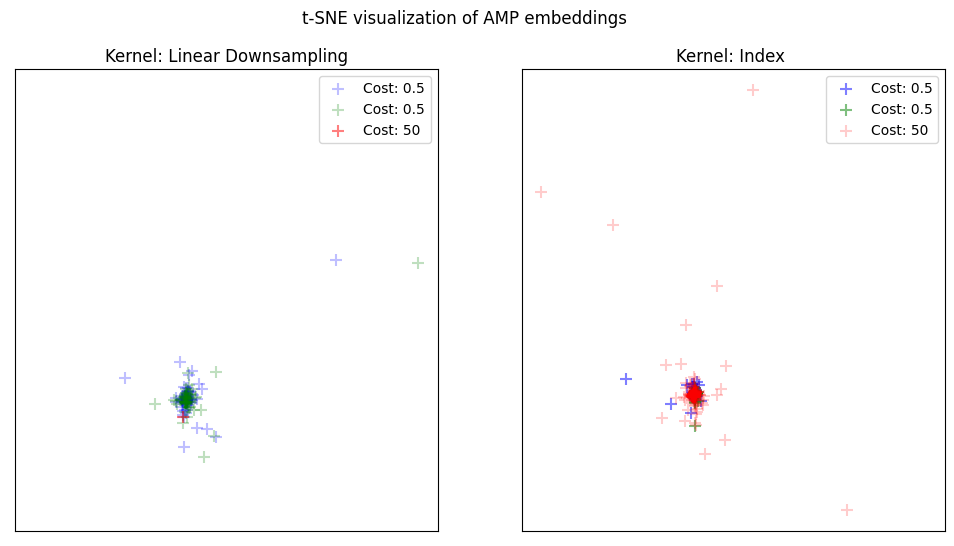

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

fid_color = {0: 'b', 1: 'g', 2: 'r'}
alpha_index = {0: 0.5, 1: 0.5, 2: 0.2}
alpha_linear = {0: 0.25, 1: 0.25, 2: 0.5}

handle = []
for c in cost:
    handle.append('Cost: ' + str(c))

for fid in np.unique(linear_fids):
    # get indices of samples with this class label
    linear_idx = np.where(linear_fids == fid)[0]
    index_idx = np.where(index_fids == fid)[0]
    color = fid_color[fid]
    # print(fid)
    ax[0].scatter(linear_tsne_embeddings[linear_idx, 0], linear_tsne_embeddings[linear_idx, 1], color=color, alpha=alpha_linear[fid], marker='+', s=80, label=handle[int(fid)])
    ax[1].scatter(index_tsne_embeddings[index_idx, 0], index_tsne_embeddings[index_idx, 1], color=color, alpha=alpha_index[fid], marker='+', s=80, label=handle[int(fid)])

ax[0].set_title('Kernel: Linear Downsampling'.format(seq_type))
ax[1].set_title('Kernel: Index '.format(seq_type))

for a in ax:
    # remove x and y axis ticks
    a.set_xticks([])
    a.set_yticks([])
    a.legend()

fig.suptitle('t-SNE visualization of {} embeddings'.format(seq_type))
